In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb
import numpy as np

In [30]:
# Folder path containing all CSV files
folder_path = r'bist30_latest_till_December22nd'

# Create an empty dictionary to store DataFrames for each short_name
subsets = {}

# Iterate through all CSV files in the folder
for file_path in glob.glob(f'{folder_path}/*.csv'):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path, parse_dates=['timestamp'])

    # Iterate over unique short_names and update or create DataFrames
    for short_name in df['short_name'].unique():
        # Create a DataFrame for each short_name if it doesn't exist
        if short_name not in subsets:
            subsets[short_name] = pd.DataFrame()

        # Concatenate the current DataFrame to the existing subset for the short_name
        subsets[short_name] = pd.concat([subsets[short_name], df[df['short_name'] == short_name]])

# Drop the 'short_name' column from each subset
for short_name in subsets:
    subsets[short_name].drop(columns=['short_name'], inplace=True)

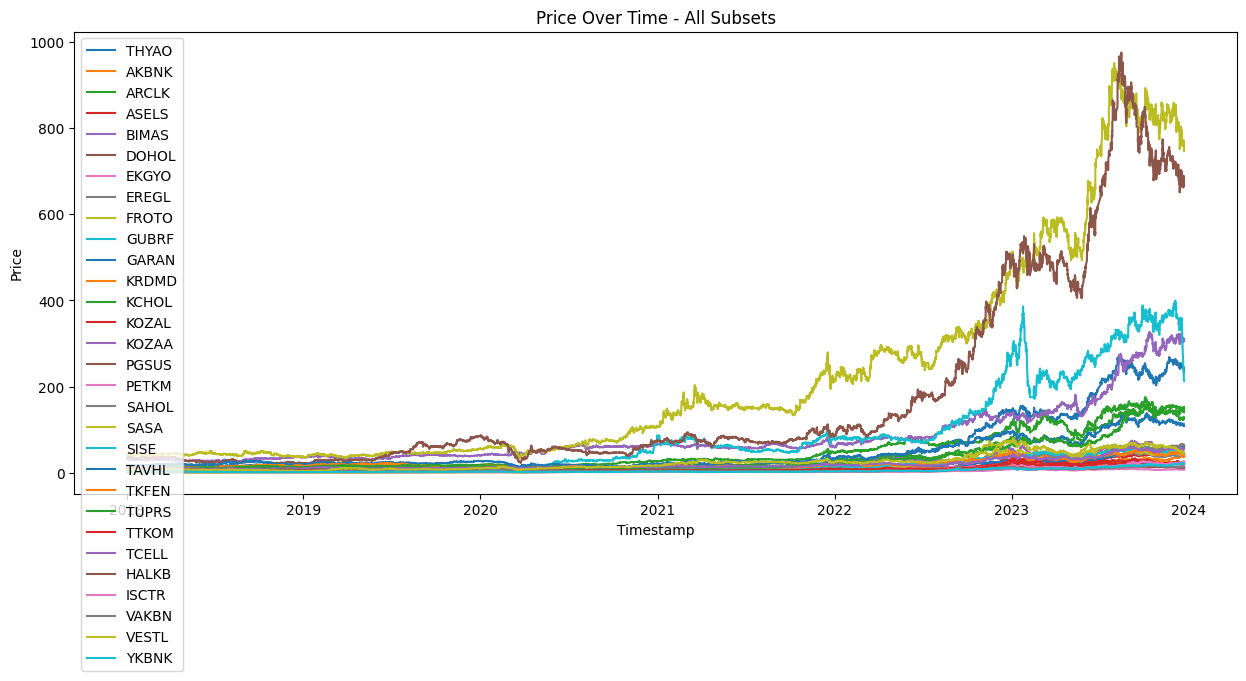

In [31]:
# Create a single plot
plt.figure(figsize=(15, 6))

# Iterate over each subset and plot 'Price Over Time'
for short_name, subset_df in subsets.items():
    # Assuming 'timestamp' and 'price' columns exist
    plt.plot(subset_df['timestamp'], subset_df['price'], label=short_name)

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Over Time - All Subsets')

# Add legend to distinguish subsets
plt.legend()

# Show the plot
plt.show()


<Figure size 1200x800 with 0 Axes>

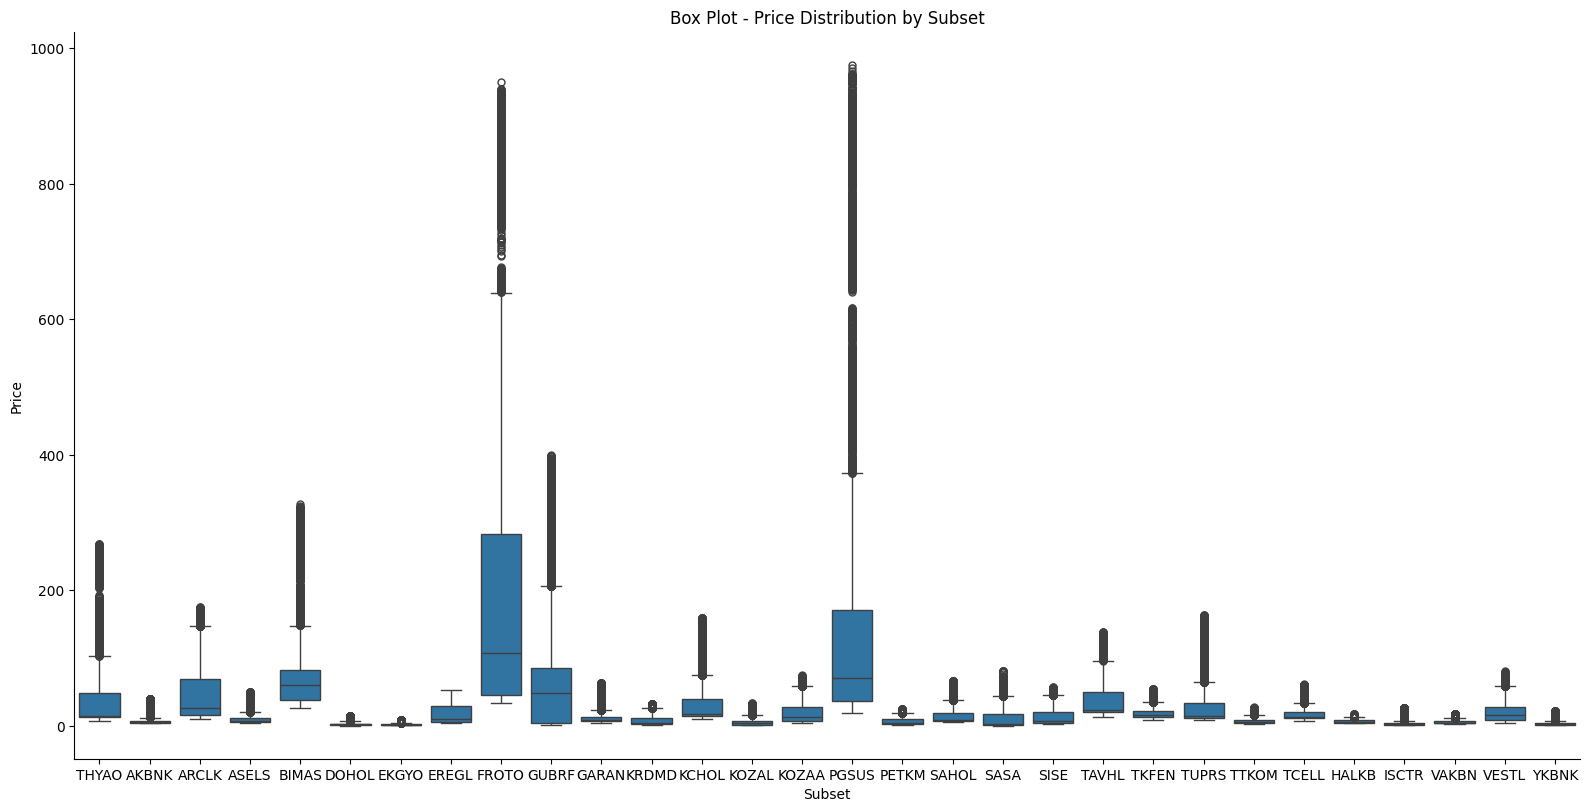

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot for each subset
plt.figure(figsize=(12, 8))

# Convert the subsets dictionary to a single DataFrame
subset_data = pd.concat(subsets.values(), keys=subsets.keys(), names=['Subset'])

# Create a categorical plot
sns.catplot(x='Subset', y='price', kind='box', data=subset_data, height=8, aspect=2)

# Set labels and title
plt.xlabel('Subset')
plt.ylabel('Price')
plt.title('Box Plot - Price Distribution by Subset')

# Show the plot
plt.show()


In [33]:
# # Access a specific subset (replace 'example_short_name' with an actual short_name)
# target_short_name = 'THYAO'
# subset_df = subsets[target_short_name]

# # Assuming 'timestamp' and 'price' columns exist
# X = subset_df[['timestamp']]  # You may need to include more features
# y = subset_df['price']
# # Transform timestamps into numerical features
# X['timestamp'] = pd.to_numeric(X['timestamp'])

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Model 1: LASSO Regression
def lasso_predictor(X_train, y_train, X_test):
    lasso_regressor = LassoCV(cv=5, random_state=42)
    lasso_regressor.fit(X_train, y_train)
    y_pred_lasso = lasso_regressor.predict(X_test)
    return y_pred_lasso

In [35]:
# Model 2: Random Forest
def rf_predictor(X_train, y_train, X_test):
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred_rf = rf_regressor.predict(X_test)
    return y_pred_rf

In [36]:
# Model 3: XGBoost with parameter tuning using RandomizedSearchCV
def xgb_predictor(X_train, y_train, X_test):
    xgb_param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    xgb_regressor = RandomizedSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        param_distributions=xgb_param_dist,
        n_iter=10,
        cv=5,
        random_state=42,
        n_jobs=-1
    )

    xgb_regressor.fit(X_train, y_train)
    y_pred_xgb = xgb_regressor.predict(X_test)
    return y_pred_xgb


In [37]:
def simple_ensemble(y_pred_rf,y_pred_xgb):
    # Assuming you have predictions stored in DataFrame columns
    # Replace these with actual predictions from your models
    predictions_rf = pd.Series(y_pred_rf, name='random_forest')
    predictions_xgb = pd.Series(y_pred_xgb, name='XGBoost')

    # Combine predictions into a DataFrame
    ensemble_df = pd.concat([predictions_rf, predictions_xgb], axis=1)

    # Calculate ensemble predictions
    ensemble_df['small_ensemble'] = ensemble_df.mean(axis=1)

    full_ens = pd.DataFrame({
        'random_forest': y_pred_rf,
        'XGBoost': y_pred_xgb
    })
    # Combine predictions into the 'full_ens' DataFrame
    full_ens['random_forest'] = predictions_rf
    full_ens['XGBoost'] = predictions_xgb

    # Calculate full ensemble predictions
    full_ens['full_ensemble'] = full_ens.mean(axis=1)


    full_ensemble_predictions = full_ens['full_ensemble']
    return full_ensemble_predictions


In [38]:
def calculate_wmape(actual, forecast):
    numerator = np.sum(np.abs(actual - forecast))
    denominator = np.sum(np.abs(actual))
    wmape = (numerator / denominator) * 100
    return wmape

In [39]:
def calculate_wmape2(actual, pred):

    # Convert inputs to numpy arrays
    actual = np.array(actual)
    pred = np.array(pred)

    # Check if the lengths of actual and pred match
    if len(actual) != len(pred):
        raise ValueError("Lengths of 'actual' and 'pred' must be the same.")


    numerator = np.sum(np.abs(actual - pred))
    denominator = np.sum(np.abs(actual))
    wmape = (numerator / denominator) * 100

    return wmape

In [47]:
def calculate_mse_manual(actual, forecast):
    n = len(actual)
    mse = np.sum((actual - forecast) ** 2) / n
    return mse

In [48]:
# Create an empty list to store results
wmape_list = []
mse_list = []

for target_short_name in subsets:
    subset_df = subsets[target_short_name]
    X = subset_df[['timestamp']]
    y = subset_df['price']

    # Assuming 'timestamp' and 'price' columns exist
    X['timestamp'] = pd.to_numeric(X['timestamp'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Make predictions
    y_pred_lasso = lasso_predictor(X_train, y_train, X_test)
    y_pred_rf = rf_predictor(X_train, y_train, X_test)
    y_pred_xgb = xgb_predictor(X_train, y_train, X_test)

    # Ensemble predictions
    full_ensemble_predictions = simple_ensemble(y_pred_rf, y_pred_xgb)

    # Calculate WMAPE for each model and ensemble
    wmape_lasso = calculate_wmape(y_test, y_pred_lasso)
    wmape_rf = calculate_wmape(y_test, y_pred_rf)
    wmape_xgb = calculate_wmape(y_test, y_pred_xgb)
    wmape_full_ensemble = calculate_wmape2(y_test, full_ensemble_predictions)

    # Evaluate models and ensemble using MSE
    mse_lasso_manual = calculate_mse_manual(y_test, y_pred_lasso)
    mse_rf_manual = calculate_mse_manual(y_test, y_pred_rf)
    mse_xgb_manual = calculate_mse_manual(y_test, y_pred_xgb)
    mse_full_ensemble_manual = calculate_mse_manual(y_test, full_ensemble_predictions)

    # Append results to the list
    wmape_list.append({
        'Market': target_short_name,
        'LASSO Regression': wmape_lasso,
        'Random Forest': wmape_rf,
        'XGBoost': wmape_xgb,
        'Ensemble': wmape_full_ensemble
    })
    mse_list.append({
        'Market': target_short_name,
        'LASSO Regression': wmape_lasso,
        'Random Forest': wmape_rf,
        'XGBoost': wmape_xgb,
        'Ensemble': wmape_full_ensemble
    })

# Create a DataFrame from the list of results
results_table1 = pd.DataFrame(wmape_list)
results_table2 = pd.DataFrame(mse_list)

# Display the results table
print("WMAPE",results_table1)
print("MSE",results_table2)


C:\Users\bar2b\AppData\Local\Temp\ipykernel_15552\3480793034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['timestamp'] = pd.to_numeric(X['timestamp'])
C:\Users\bar2b\AppData\Local\Temp\ipykernel_15552\3480793034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['timestamp'] = pd.to_numeric(X['timestamp'])
C:\Users\bar2b\AppData\Local\Temp\ipykernel_15552\3480793034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

WMAPE    Market  LASSO Regression  Random Forest   XGBoost  Ensemble
0   THYAO         78.376486       0.499075  2.036172  1.139013
1   AKBNK         45.679537       0.541569  2.215534  1.201725
2   ARCLK         40.708941       0.512555  1.973410  1.081731
3   ASELS         44.254638       0.553768  2.121351  1.170933
4   BIMAS         35.498290       0.445417  1.674228  0.921871
5   DOHOL         45.101295       0.590847  2.253970  1.252200
6   EKGYO         45.296915       0.598324  2.271574  1.253718
7   EREGL         28.329257       0.490624  1.952765  1.074592
8   FROTO         49.861822       0.537283  1.965667  1.094702
9   GUBRF         57.036207       0.661860  2.894811  1.583805
10  GARAN         45.582855       0.550616  2.260952  1.223420
11  KRDMD         38.230221       0.619127  2.505657  1.383849
12  KCHOL         51.192789       0.483568  1.880795  1.038897
13  KOZAL         54.735683       0.667364  2.629416  1.444344
14  KOZAA         32.074961       0.702307  2.625